In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import os
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'
queries_dir = './queries/'

In [3]:
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
#cur.execute('SET search_path to {}'.format(schema_name))

In [4]:
# Load in the query from file
query='DROP TABLE IF EXISTS mimiciii.heartrates;'
cursor.execute(query)
f = os.path.join(queries_dir,'heart-rates.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'heartrates\' using {} ...'.format(f),end=' ')
cursor.execute(query)
print('done.')

Generating table 'heartrates' using ./queries/heart-rates.sql ... done.


In [5]:
query = """
select *
from mimiciii.heartrates;
"""
cursor.execute(query)
# Load the result of the query into a dataframe
hr = pd.read_sql_query(query, connect)

In [6]:
hr.dtypes

subject_id                       int64
hadm_id                          int64
icustay_id                     float64
value                           object
charttime               datetime64[ns]
hospital_expire_flag             int64
dtype: object

In [7]:
hr.head()

,subject_id,hadm_id,icustay_id,value,charttime,hospital_expire_flag
0,3,145834,211552.0,88,2101-10-25 04:00:00,0
1,4,185777,294638.0,80,2191-03-16 08:00:00,0
2,6,107064,228232.0,79,2175-05-31 02:00:00,0
3,13,143045,263738.0,98,2167-01-11 04:55:00,0
4,13,143045,263738.0,82,2167-01-11 05:00:00,0


In [8]:
hr.loc[hr.hospital_expire_flag == 0].subject_id.value_counts().head(10)

12613    6330
21280    4872
11923    4106
19911    4043
15204    4007
3014     3786
7679     3760
6365     3746
6975     3722
20415    3634
Name: subject_id, dtype: int64

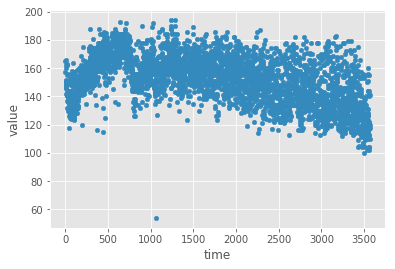

In [9]:
per_sub = hr.loc[hr.subject_id == 20415].sort_values(by='charttime')
per_sub['time'] = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
per_sub['value'] = per_sub['value'].astype('int')
per_sub.plot.scatter(x='time',y='value')

In [42]:
hr.loc[hr.hospital_expire_flag == 1].subject_id.value_counts().head()

517      2922
6702     2768
14249    2740
4894     1932
1113     1928
Name: subject_id, dtype: int64

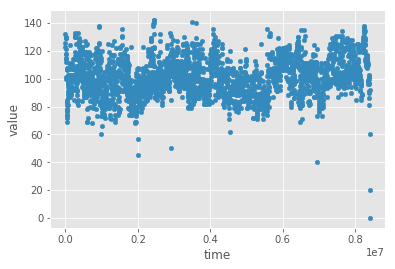

In [49]:
per_sub = hr.loc[hr.subject_id == 14249].sort_values(by='charttime')
per_sub['time'] = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()
per_sub['value'] = per_sub['value'].astype('int')
per_sub.plot.scatter(x='time',y='value')

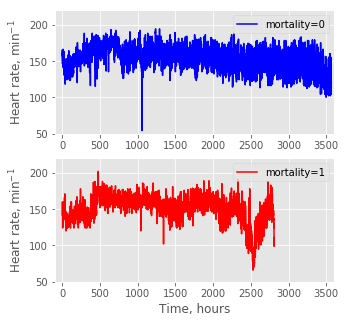

In [51]:
f, axs = plt.subplots(2,1,figsize=(5,5))

per_sub = hr.loc[hr.subject_id == 20415].sort_values(by='charttime')
x = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
y = per_sub['value'].astype('int')
axs[0].plot(x,y,'-',color='blue',label='mortality=0')
axs[0].legend(loc='upper right')
#axs[0].set_xlabel('Time, hours')
axs[0].set_ylabel(r'Heart rate, min$^{-1}$')
axs[0].set_xlim(-100, 3600)
axs[0].set_ylim(50, 220)

per_sub = hr.loc[hr.subject_id == 517].sort_values(by='charttime')
x = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
y = per_sub['value'].astype('int')
axs[1].plot(x,y,'-',color='red',label='mortality=1')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Time, hours')
axs[1].set_ylabel(r'Heart rate, min$^{-1}$')
axs[1].set_xlim(-100, 3600)
axs[1].set_ylim(50, 220)

plt.savefig('heartrate.pdf')

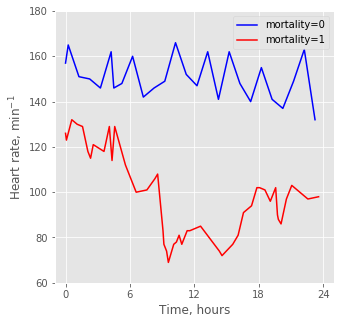

In [70]:
f, axs = plt.subplots(1,1,figsize=(5,5))

per_sub = hr.loc[hr.subject_id == 20415].sort_values(by='charttime')
x = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
y = per_sub['value'].astype('int')
axs.plot(x.loc[x < 24],y.loc[x < 24],'-',color='blue',label='mortality=0')
#axs.legend(loc='upper right')
#axs[0].set_xlabel('Time, hours')
#axs.set_ylabel(r'Heart rate, min$^{-1}$')
#axs.set_xlim(0, 24)
#axs.set_ylim(50, 200)

per_sub = hr.loc[hr.subject_id == 14249].sort_values(by='charttime')
x = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
y = per_sub['value'].astype('int')
axs.plot(x.loc[x < 24],y.loc[x < 24],'-',color='red',label='mortality=1')
axs.legend(loc='upper right')
axs.set_xlabel('Time, hours')
axs.set_ylabel(r'Heart rate, min$^{-1}$')
axs.set_xlim(-1, 25)
axs.set_ylim(60, 180)
axs.set_xticks([0,6,12,18,24])

plt.savefig('heartrate_24.pdf')